Found 300 files belonging to 10 classes.
Found 300 files belonging to 10 classes.
Found 2400 files belonging to 10 classes.
10
['Battery', 'Keyboard', 'Microwave', 'Mobile', 'Mouse', 'PCB', 'Player', 'Printer', 'Television', 'Washing Machine']


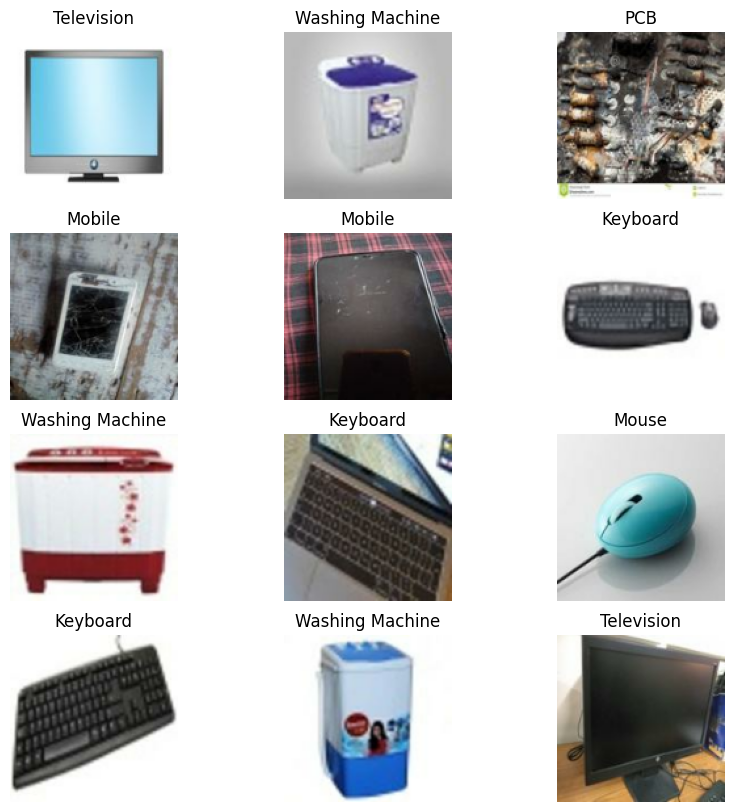

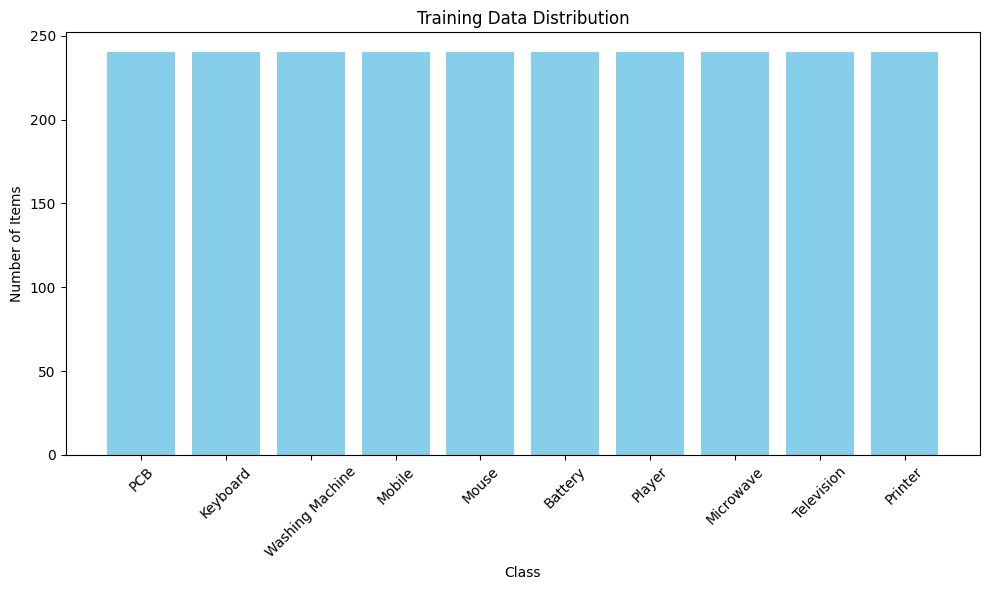

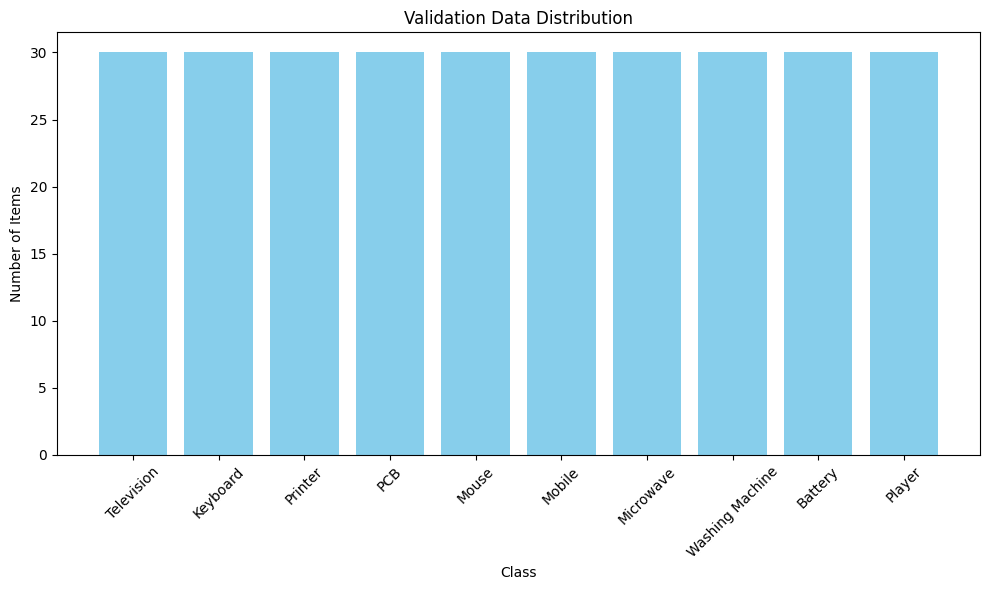

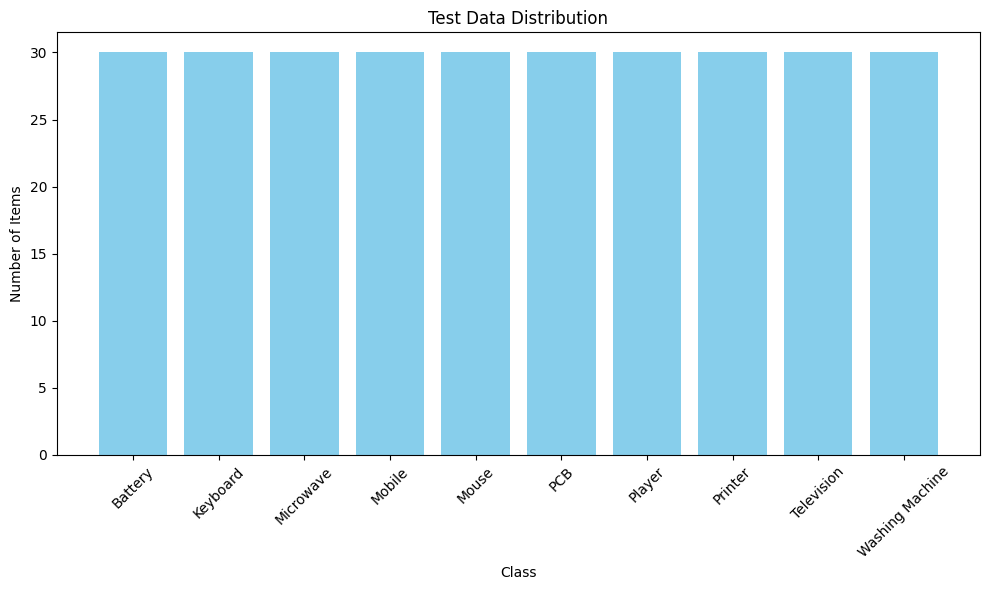

In [5]:
import tensorflow as tf  # Core TensorFlow library
import numpy as np
from tensorflow.keras import layers, models, optimizers, callbacks  # Layers, model creation, optimizers, and training callbacks

from tensorflow.keras.models import Sequential, load_model  # For sequential model architecture and loading saved models

from tensorflow.keras.applications import EfficientNetV2B0  # Pretrained EfficientNetV2B0 model for transfer learning

from tensorflow.keras.applications.efficientnet import preprocess_input  # Preprocessing function specific to EfficientNet

import numpy as np  # Numerical operations and array handling

import matplotlib.pyplot as plt  # Plotting graphs and images

import seaborn as sns  # Plotting graphs and images

from sklearn.metrics import confusion_matrix, classification_report

testpath=r'E:\AICTE INTERNSHIP\modified-dataset\test'
trainpath=r'E:\AICTE INTERNSHIP\modified-dataset\train'
validpath=r'E:\AICTE INTERNSHIP\modified-dataset\val'

datavalid=tf.keras.utils.image_dataset_from_directory(validpath,shuffle=True,batch_size=32,image_size=(128,128),validation_split=False)
datatest=tf.keras.utils.image_dataset_from_directory(testpath,shuffle=False,image_size=(128,128),batch_size=32,validation_split=False)
datatrain=tf.keras.utils.image_dataset_from_directory(trainpath,shuffle=True,image_size=(128,128),batch_size=32,validation_split=False)

class_names = datatrain.class_names
print(len(class_names))
print(class_names)

# Set the size of the entire figure (width=10, height=10 inches)
plt.figure(figsize=(10, 10))

# Take one batch from the dataset and iterate over the images and labels
for images, labels in datatrain.take(1):
    # Display the first 12 images from the batch
    for i in range(12):
        # Create a 4x3 grid of subplots and select the (i+1)th position
        ax = plt.subplot(4, 3, i + 1)

        # Display the image; convert the tensor to a NumPy array and ensure correct type
        plt.imshow(images[i].numpy().astype("uint8"))

        # Set the title of the subplot to the class name of the image
        plt.title(class_names[labels[i]])

        # Remove axis ticks and labels for clarity
        plt.axis("off")

def plot_class_distribution(dataset, title="Class Distribution"):

    class_counts = {}  # Dictionary to hold the count of each class

    # Iterate through the batches in the dataset
    for images, labels in dataset:
        # Convert labels tensor to numpy array and loop through each label
        for label in labels.numpy():
            class_name = dataset.class_names[label]  # Get class name using label index
            # Increment the count for this class
            class_counts[class_name] = class_counts.get(class_name, 0) + 1


    # Prepare data for plotting
    class_names = list(class_counts.keys())  # List of class names
    counts = list(class_counts.values())     # Corresponding counts for each class

    # Create the bar plot
    plt.figure(figsize=(10, 6))  # Set the figure size
    plt.bar(class_names, counts, color='skyblue')  # Draw bars with class counts
    plt.xlabel("Class")  # X-axis label
    plt.ylabel("Number of Items")  # Y-axis label
    plt.title(title)  # Plot title
    plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
    plt.tight_layout()  # Adjust layout to prevent clipping
    plt.show()  # Display the plot
    
plot_class_distribution(datatrain, "Training Data Distribution")
plot_class_distribution(datavalid, "Validation Data Distribution")
plot_class_distribution(datatest, "Test Data Distribution")

In [37]:

data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal"),
    tf.keras.layers.RandomRotation(0.1),
    tf.keras.layers.RandomZoom(0.1),
  #  tf.keras.layers.RandomContrast(0.1),
    tf.keras.layers.RandomTranslation(0.1, 0.1)
    
])
base_model = tf.keras.applications.EfficientNetV2B0(
    input_shape=(128, 128, 3),
    include_top=False,
    weights='imagenet'
)
base_model.trainable = True
for layer in base_model.layers[:97]:
    layer.trainable = False

NUM_CLASSES = 10

model = tf.keras.Sequential([
   layers.Input(shape=(128, 128, 3)),
        data_augmentation,
        base_model,
        layers.GlobalAveragePooling2D(),
        layers.Dropout(0.2),
        layers.Dense(256, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(1e-4)),
        layers.Dropout(0.2),
        layers.Dense(NUM_CLASSES, activation='softmax')
])
    
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.000101),
              loss = tf.keras.losses.SparseCategoricalCrossentropy(), 
              metrics=['Accuracy'])

    
# Define an EarlyStopping callback to stop training when validation loss stops improving
early = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',            # Metric to monitor (validation loss here)
    patience=5,                   # Number of epochs to wait after last improvement before stopping
    restore_best_weights=True     # After stopping, restore the model weights from the epoch with the best val_loss
)

from tensorflow.keras.callbacks import ReduceLROnPlateau

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',     # Metric to monitor
    factor=0.1,             # Reduce learning rate by this factor
    patience=4,             # Number of epochs with no improvement before reducing
    verbose=1,              # Print messages
    min_lr=1e-6             # Lower bound on the learning rate
)

# Set the number of epochs to train the model
epochs = 20

# Train the model on the training dataset 'datatrain'
history = model.fit(
    datatrain,                      # Training data generator or dataset
    validation_data=datavalid,      # Validation data generator or dataset
    epochs=epochs,                  # Number of training epochs
    batch_size=100,                 # Number of samples per gradient update
    callbacks=[early, reduce_lr]               # List of callbacks to apply during training (e.g., early stopping)
)


Epoch 1/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 76s 645ms/step - Accuracy: 0.2740 - loss: 2.1589 - val_Accuracy: 0.7933 - val_loss: 1.1548 - learning_rate: 1.0100e-04
Epoch 2/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 46s 619ms/step - Accuracy: 0.7663 - loss: 1.0438 - val_Accuracy: 0.9100 - val_loss: 0.4736 - learning_rate: 1.0100e-04
Epoch 3/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 48s 645ms/step - Accuracy: 0.8490 - loss: 0.5603 - val_Accuracy: 0.9267 - val_loss: 0.3072 - learning_rate: 1.0100e-04
Epoch 4/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 50s 672ms/step - Accuracy: 0.8919 - loss: 0.4130 - val_Accuracy: 0.9400 - val_loss: 0.2659 - learning_rate: 1.0100e-04
Epoch 5/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 50s 663ms/step - Accuracy: 0.9029 - loss: 0.3511 - val_Accuracy: 0.9467 - val_loss: 0.2300 - learning_rate: 1.0100e-04
Epoch 6/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 51s 676ms/step - Accuracy: 0.9440 - loss: 0.2321 - val_Accuracy: 0.9467 - val_loss: 0.2170 - learning_rate: 1.0100e-04
Epoch 7/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 50s 668ms/step - Acc

In [39]:
model.summary()

Model: "sequential_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ sequential_10 (Sequential)           │ (None, 128, 128, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ efficientnetv2-b0 (Functional)       │ (None, 4, 4, 1280)          │       5,919,312 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_5           │ (None, 1280)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_11 (Dropout)                 │ (None, 1280)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_11 (Dense)                     │ (None, 256)                 │         327,936 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_12 (Dropout)                 │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_12 (Dense)                     │ (None, 10)                  │           2,570 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 17,298,792 (65.99 MB)

 Trainable params: 5,524,486 (21.07 MB)

 Non-trainable params: 725,332 (2.77 MB)

 Optimizer params: 11,048,974 (42.15 MB)

In [41]:
base_model.summary() # Print the architecture summary of the base model

Model: "efficientnetv2-b0"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_15 (InputLayer)   │ (None, 128, 128, 3)       │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ rescaling_5 (Rescaling)       │ (None, 128, 128, 3)       │               0 │ input_layer_15[0][0]       │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ normalization_5               │ (None, 128, 128, 3)       │               0 │ rescaling_5[0][0]          │
│ (Normalization)               │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ stem_conv (Conv2D)            │ (None, 64, 64, 32)        │             864 │ normalization_5[0][0]      │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ stem_bn (BatchNormalization)  │ (None, 64, 64, 32)        │             128 │ stem_conv[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ stem_activation (Activation)  │ (None, 64, 64, 32)        │               0 │ stem_bn[0][0]              │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block1a_project_conv (Conv2D) │ (None, 64, 64, 16)        │           4,608 │ stem_activation[0][0]      │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block1a_project_bn            │ (None, 64, 64, 16)        │              64 │ block1a_project_conv[0][0] │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block1a_project_activation    │ (None, 64, 64, 16)        │               0 │ block1a_project_bn[0][0]   │
│ (Activation)                  │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block2a_expand_conv (Conv2D)  │ (None, 32, 32, 64)        │           9,216 │ block1a_project_activatio… │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block2a_expand_bn             │ (None, 32, 32, 64)        │             256 │ block2a_expand_conv[0][0]  │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block2a_expand_activation     │ (None, 32, 32, 64)        │               0 │ block2a_expand_bn[0][0]    │
│ (Activation)                  │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block2a_project_conv (Conv2D) │ (None, 32, 32, 32)        │           2,048 │ block2a_expand_activation… │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block2a_project_bn            │ (None, 32, 32, 32)        │             128 │ block2a_project_conv[0][0] │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼───────────────

 Total params: 5,919,312 (22.58 MB)

 Trainable params: 5,193,980 (19.81 MB)

 Non-trainable params: 725,332 (2.77 MB)

In [43]:
### Plotting Training and Validation Accuracy and Loss Over Epochs

acc = history.history['Accuracy']           # Training accuracy
val_acc = history.history['val_Accuracy']   # Validation accuracy
loss = history.history['loss']              # Training loss
val_loss = history.history['val_loss']      # Validation loss

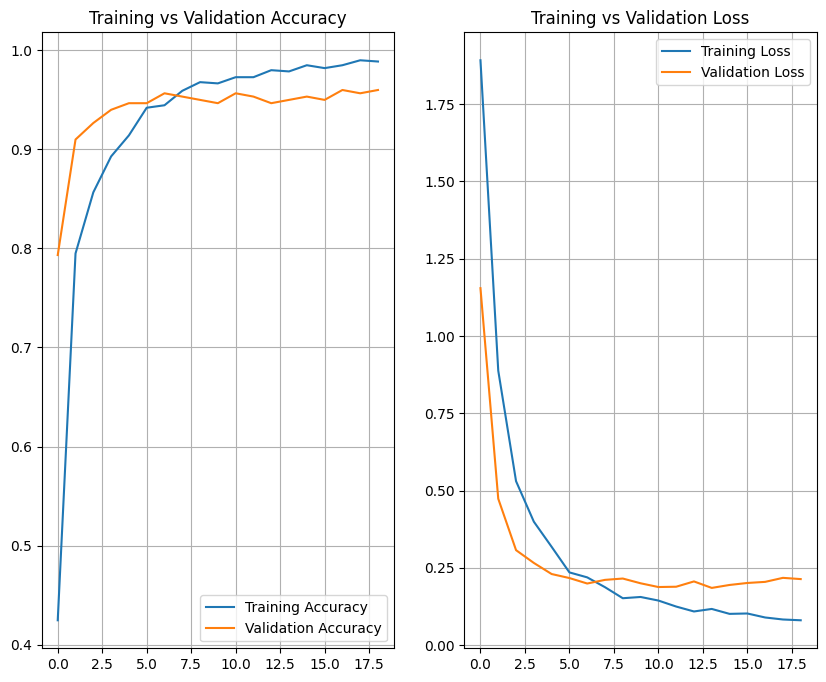

In [45]:
epochs_range = range(len(acc))              # X-axis range based on number of epochs

plt.figure(figsize=(10, 8))                 # Set overall figure size

plt.subplot(1, 2, 1)                        # 1 row, 2 columns, position 1
plt.plot(epochs_range, acc, label='Training Accuracy')       # Plot training accuracy
plt.plot(epochs_range, val_acc, label='Validation Accuracy') # Plot validation accuracy
plt.legend(loc='lower right')              # Show legend at lower right
plt.title('Training vs Validation Accuracy') # Set title for accuracy plot
plt.grid(True)

plt.subplot(1, 2, 2)                        # 1 row, 2 columns, position 2
plt.plot(epochs_range, loss, label='Training Loss')          # Plot training loss
plt.plot(epochs_range, val_loss, label='Validation Loss')    # Plot validation loss
plt.legend(loc='upper right')              # Show legend at upper right
plt.title('Training vs Validation Loss')    # Set title for loss plot
plt.grid(True)

plt.show()                                  # Display the plots


In [47]:
loss, accuracy = model.evaluate(datatest)
print(f'Test accuracy is{accuracy:.4f}, Test loss is {loss:.4f}')

10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 182ms/step - Accuracy: 0.9647 - loss: 0.1688
Test accuracy is0.9700, Test loss is 0.1341


In [49]:
# Save the full model in .keras format 
model.save('best_model.keras')

In [51]:
### Evaluate Model Performance on Test Data using Confusion Matrix and Classification Report

# Extract true labels from all batches
y_true = np.concatenate([y.numpy() for x, y in datatest], axis=0)  # Ground truth labels

# Get predictions as probabilities and then predicted classes
y_pred_probs = model.predict(datatest)

# Class with highest probability
y_pred = np.argmax(y_pred_probs, axis=1)                           

# Print confusion matrix and classification report
print(confusion_matrix(y_true, y_pred))                            
print(classification_report(y_true, y_pred))                     


10/10 ━━━━━━━━━━━━━━━━━━━━ 6s 404ms/step
[[29  0  0  0  0  1  0  0  0  0]
 [ 1 29  0  0  0  0  0  0  0  0]
 [ 0  0 27  0  0  0  1  1  1  0]
 [ 0  0  0 30  0  0  0  0  0  0]
 [ 0  0  0  0 29  0  0  1  0  0]
 [ 0  0  0  0  0 30  0  0  0  0]
 [ 1  0  0  0  0  0 29  0  0  0]
 [ 0  0  0  0  0  0  0 30  0  0]
 [ 0  0  1  0  0  1  0  0 28  0]
 [ 0  0  0  0  0  0  0  0  0 30]]
              precision    recall  f1-score   support

           0       0.94      0.97      0.95        30
           1       1.00      0.97      0.98        30
           2       0.96      0.90      0.93        30
           3       1.00      1.00      1.00        30
           4       1.00      0.97      0.98        30
           5       0.94      1.00      0.97        30
           6       0.97      0.97      0.97        30
           7       0.94      1.00      0.97        30
           8       0.97      0.93      0.95        30
           9       1.00      1.00      1.00        30

    accuracy                    

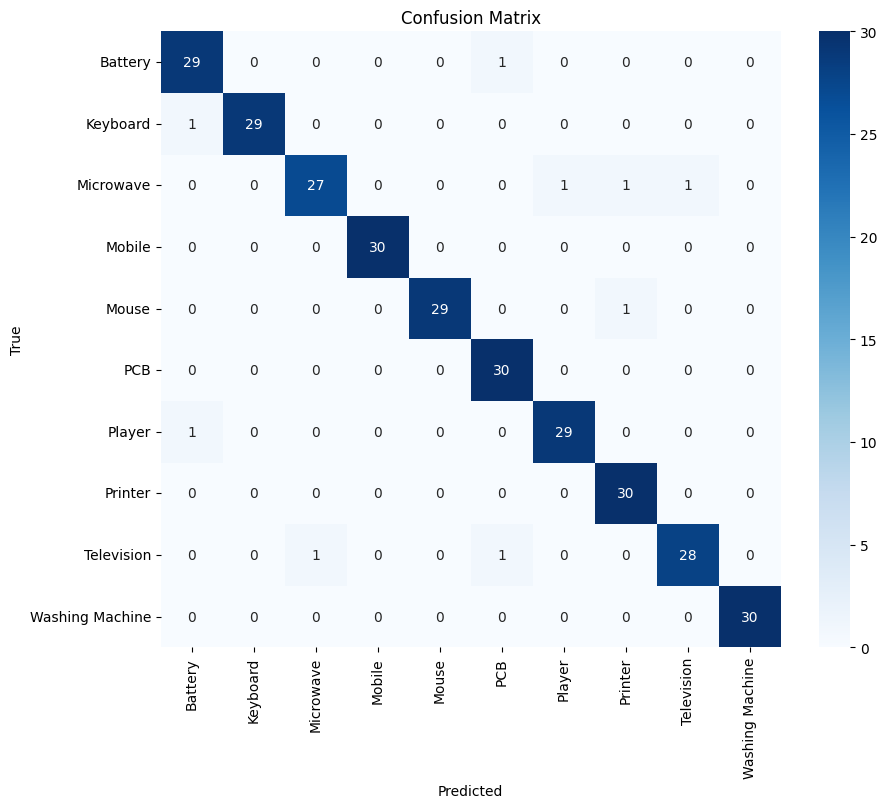

In [53]:
### Plot Confusion Matrix as Heatmap for Better Visualization

cm = confusion_matrix(y_true, y_pred)                                     # Compute confusion matrix
                                                     # Import seaborn for visualization

plt.figure(figsize=(10, 8))                                               # Set figure size
sns.heatmap(cm, annot=True, fmt='d', 
            xticklabels=class_names, 
            yticklabels=class_names, 
            cmap='Blues')                                                 # Create heatmap with class labels

plt.xlabel('Predicted')                                                   # Label for x-axis
plt.ylabel('True')                                                        # Label for y-axis
plt.title('Confusion Matrix')                                             # Title for the plot
plt.show()                                                                # Display the plot


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 242ms/step


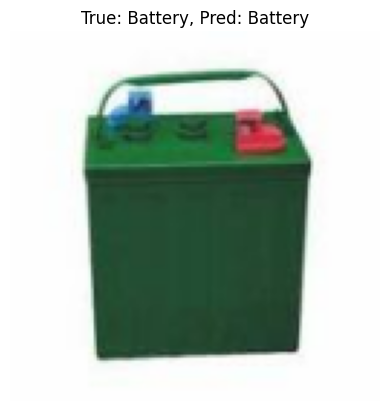

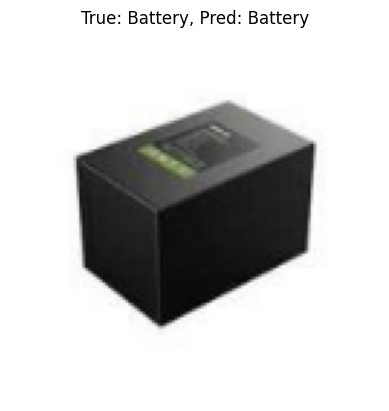

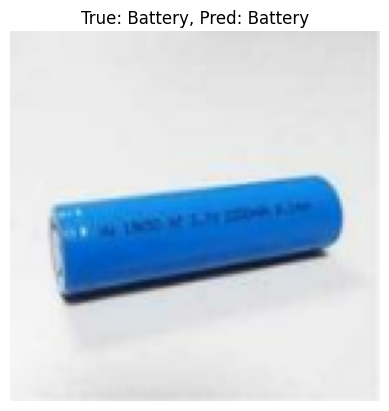

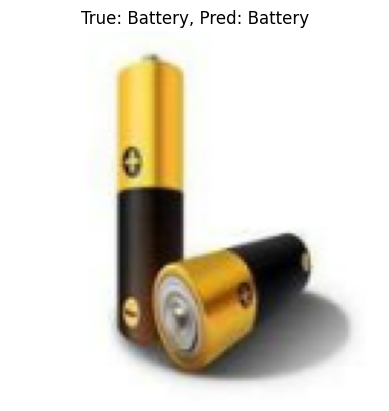

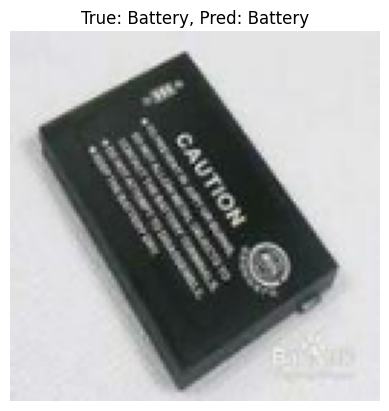

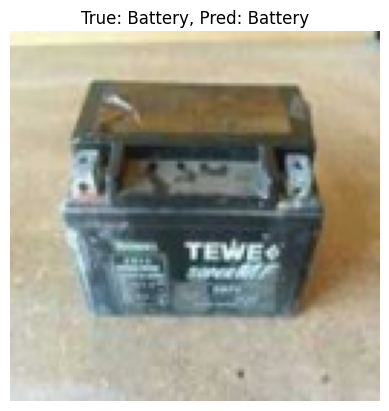

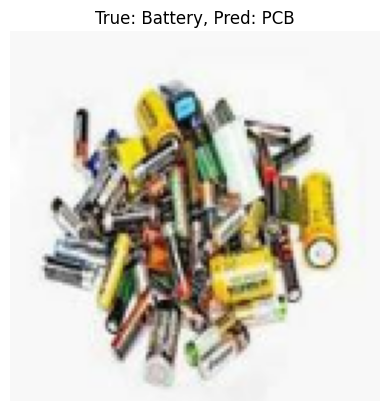

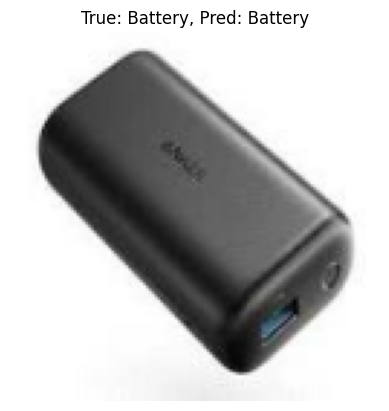

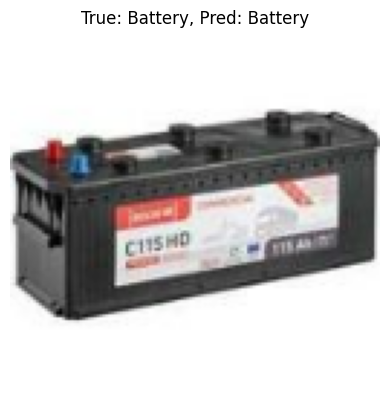

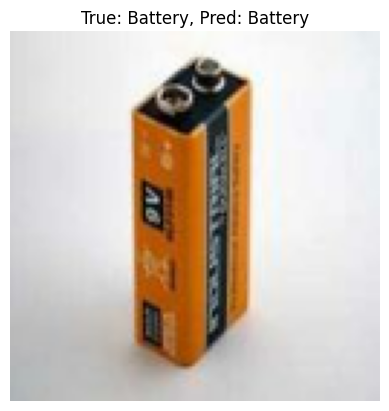

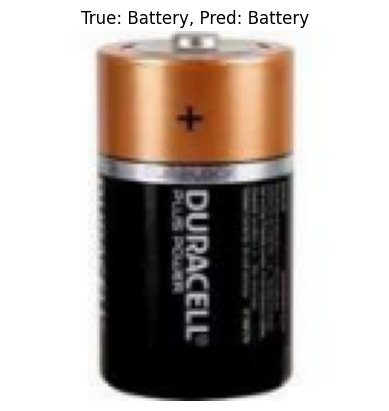

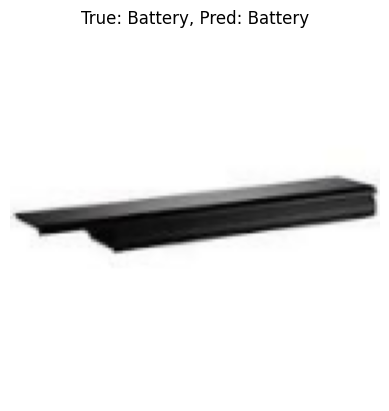

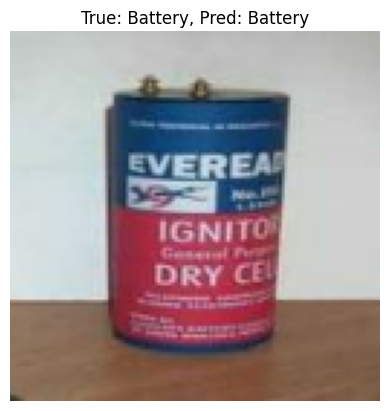

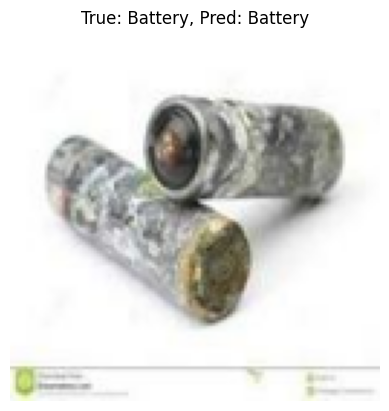

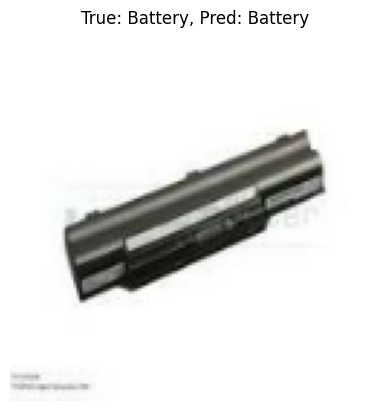

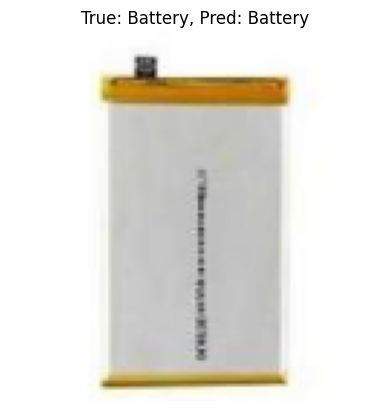

In [67]:
### Display Sample Predictions: True Labels vs Predicted Labels

class_names = datatest.class_names                                           # Get class names from test dataset

for images, labels in datatest.take(1):                                     # Take one batch from test data
    predictions = model.predict(images)                                     # Predict class probabilities
    pred_labels = tf.argmax(predictions, axis=1)                            # Get predicted class indices

    for i in range(16):                                                      # Display first 8 images from batch
        plt.imshow(images[i].numpy().astype("uint8"))                       # Convert tensor to image
        plt.title(f"True: {class_names[labels[i]]}, Pred: {class_names[pred_labels[i]]}")  # Title with labels
        plt.axis("off")                                                     # Hide axes
        plt.show()                                                          # Show image



In [63]:
# Define your class labels
class_names = ['Battery', 'Keyboard', 'Microwave', 'Mobile', 'Mouse', 'PCB', 'Player', 'Printer', 'Television', 'Washing Machine']

# Load your Keras model
model = tf.keras.models.load_model('best_model.keras')

In [86]:
import os
os.system("start streamlit run app.py")

0